In [4]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.io

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir


%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [2]:
# Input data
n_sequence=1
spatial_points = 65
spatial_points_ = spatial_points
lyap_exp = 0.0461
n_train = 2000
n_test = 2000
forget = 100
parallel_runs = 1
ks_data_origin, xx_, tt = data1D.kuramoto_sivashinsky_from_dataset(sequence_length=n_train+n_test, n_sequence=n_sequence)
# ks_data_origin=ks_data_origin+np.random.rand(ks_data_origin.shape[0],ks_data_origin.shape[1],ks_data_origin.shape[2])
ks_data_train = ks_data_origin[:, :n_train, :]
input_shape=ks_data_train.shape

In [3]:
b = Reservoir(n_res=2000, res_scale=0.5, res_encoding=None, res_enc_param=np.pi,
             input_scale=1, input_encoding=None,
             random_projection='simulation', weights_type='gaussian',
             activation_fun='tanh', activation_param=1,
             parallel_runs=1,  bias_scale=0.8, leak_rate=0.6,
             pred_horizon=1, rec_pred_steps=200, forget = forget,
             train_method='ridge', train_param=100, verbose=1,
             scale_input_MinMax = (-1, 1), scale_res_MinMax = None, scale_output_MinMax = (-1, 1)
            )

# Algorithm training
b.fit(ks_data_train);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.16857647895812988 s



Reservoir iterations complete. 		Elapsed time: 3.2525017261505127 s
(1, 1900, 2065)
concat_states.shape = (1900, 2065)
y.shape = (1900, 65)
Training complete. 			Elapsed time: 0.6604766845703125 s
Training score: 0.9981560809802185


In [9]:
# testing data
# ks_data_test, _, _ = data1D.kuramoto_sivashinsky_matlab(sequence_length=n_test, n_sequence=n_sequence, spatial_points=spatial_points)
# ks_data_test = ks_data_origin

parallel = 200
ks_data_test = ks_data_origin[:, n_train:, :]

In [10]:
# Algorithm testing
# b.forget = n_test - b.pred_horizon*b.rec_pred_steps - parallel
# b.parallel_runs = parallel_runs
pred_output, rmse, rmse_vec, rmse_vert = b.predict_and_score(ks_data_test, detailed_score=True, 
                                                  parallel=parallel)
# print(pred_output[:4, :5])
# print(rmse.shape)
print(rmse_vec[:5])
print(rmse_vert[:5])

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.0006182193756103516 s



Reservoir iterations complete. 		Elapsed time: 53.79171872138977 s
Testing complete. 			Elapsed time: 0.10261249542236328 s
Testing score: 0.06262060690871799
[0.03500813 0.04491096 0.05454185 0.06393126 0.07310101]
[0.45696399 0.45693725 0.45904537 0.46251728 0.4667764 ]


best plot is at 130


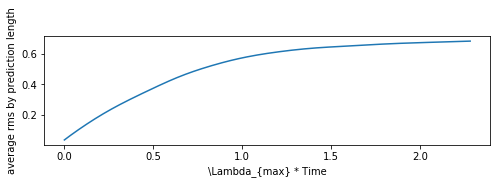

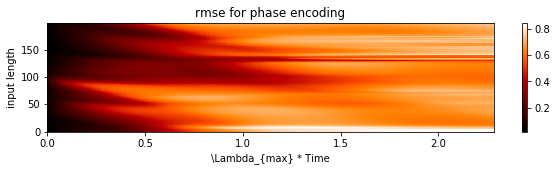

In [6]:
b.forget = n_test - b.pred_horizon*b.rec_pred_steps - parallel
total_pred = (rmse.shape[1])
length_input = pred_output.shape[0] - total_pred
time_input = range(rmse.shape[0])
time_pred = tt[0:total_pred]*lyap_exp

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by prediction length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[:], rmse_vec[:])
# scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
# scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
plt.show;

plt.figure(2,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred[:], time_input[:], rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;
print('best plot is at '+str(np.argmin(rmse_vert)))

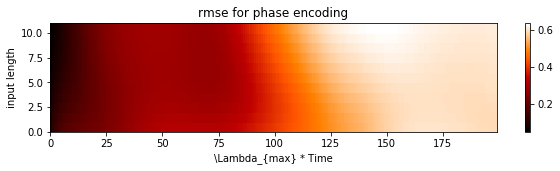

In [7]:
plt.figure(2,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh( rmse[99:110,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

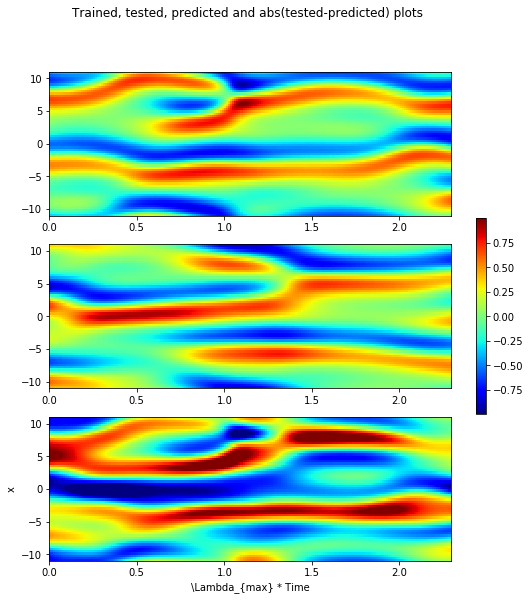

In [11]:
spatial_points = spatial_points_
xx = xx_
n_input = np.argmin(rmse_vert)
# i=0
# time = (tt[0:n_input] if i==0 else tt[0:total_pred])*lyap_exp
# total_pred = b.pred_horizon*b.rec_pred_steps
total_pred = b.rec_pred_steps
# print(total_pred)

# n_input = 500 #round(pred_output.shape[0]/2-300)


if b.random_projection == 'PRL' and b.l != 0:
    xx = xx[b.l:-b.l]
    input_data = ks_data_test[0, b.forget:b.forget+total_pred, b.l:-b.l]
    targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, b.l:-b.l]
else:
    input_data = ks_data_test[0, b.forget:b.forget+total_pred, :]
    targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, :]

prediction = pred_output[n_input, :].reshape(targetted_data.shape)

vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
# print(targetted_data.shape)
# print(prediction.shape)
# datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
datum = [targetted_data, prediction, targetted_data-prediction]
# print(datum[0].shape)
# time = (tt[0:n_input+b.forget] if i==0 else tt[0:total_pred])*lyap_exp
# xx_axs, time_axs = np.mgrid[xx, time]
if b.random_projection == 'PRL':
    spatial_points = spatial_points - 2 * b.l
xx_axs = np.zeros((spatial_points, total_pred))
time_axs = np.zeros((spatial_points, total_pred))
for i in range(total_pred):
    xx_axs[:, i] = xx
for i in range(spatial_points):
    time_axs[i, :] = (tt[n_input+b.forget:n_input+b.forget+total_pred]-tt[n_input+b.forget])*lyap_exp
for i in range(3):
    # im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
    im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

# plt.figure(3,figsize=(9,2.5))
# im=plt.pcolormesh(time_axs, xx_axs, datum[2].T, cmap='gray')
# plt.colorbar(im)
# # plt.savefig('DND_input_data.png')